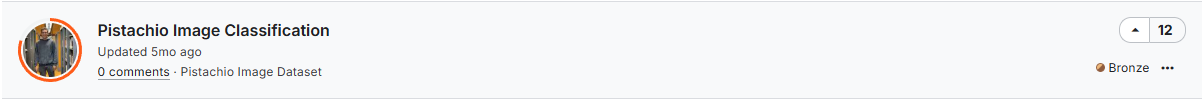

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
data_dir = r'D:\code_study\ML_CODE\dataSets\Pistachio_Image_Dataset\Pistachio_Image_Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    file_path = os.path.join(data_dir, fold)
    if not os.path.isdir(file_path):
        continue
    fpath = os.listdir(file_path)
    
    for f in fpath:
        fil_path=os.path.join(file_path,f)
        filepaths.append(fil_path)
        labels.append(fold)

f_series=pd.Series(filepaths,name='filepaths')
l_series=pd.Series(labels,name='labels')
df=pd.concat([f_series, l_series], axis= 1)
df


,filepaths,labels
0,D:\code_study\ML_CODE\dataSets\Pistachio_Image...,Kirmizi_Pistachio
1,D:\code_study\ML_CODE\dataSets\Pistachio_Image...,Kirmizi_Pistachio
2,D:\code_study\ML_CODE\dataSets\Pistachio_Image...,Kirmizi_Pistachio
3,D:\code_study\ML_CODE\dataSets\Pistachio_Image...,Kirmizi_Pistachio
4,D:\code_study\ML_CODE\dataSets\Pistachio_Image...,Kirmizi_Pistachio
...,...,...
2143,D:\code_study\ML_CODE\dataSets\Pistachio_Image...,Siirt_Pistachio
2144,D:\code_study\ML_CODE\dataSets\Pistachio_Image...,Siirt_Pistachio
2145,D:\code_study\ML_CODE\dataSets\Pistachio_Image...,Siirt_Pistachio
2146,D:\code_study\ML_CODE\dataSets\Pistachio_Image...,Siirt_Pistachio


In [3]:
labels_count = df['labels'].value_counts().reset_index()
labels_count

,index,labels
0,Kirmizi_Pistachio,1232
1,Siirt_Pistachio,916


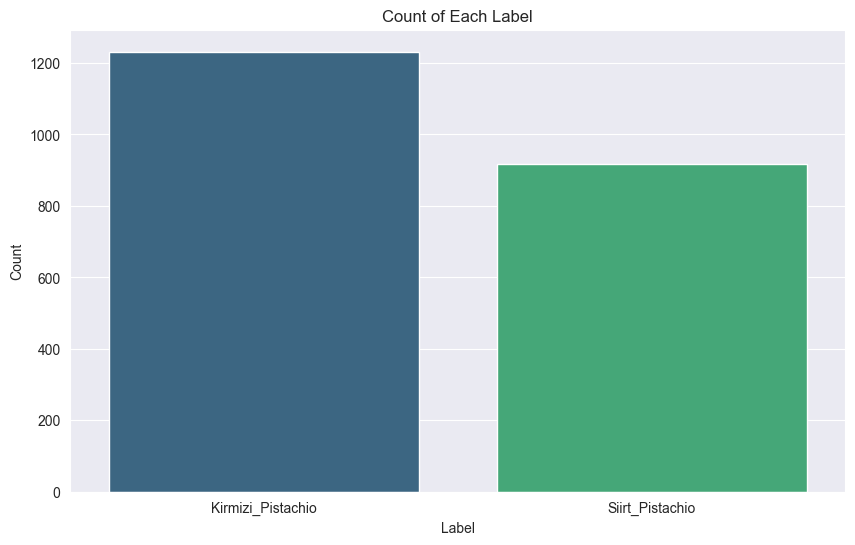

In [4]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='index', y='labels', data=labels_count, palette='viridis')

# Add title and labels
plt.title('Count of Each Label')
plt.xlabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()

In [5]:
train_df, dummy_df = train_test_split(df,  test_size= 0.2, shuffle= True, random_state= 43)

# valid and test dataframe 10% validate  10% test
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 43)

In [6]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 1718 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.


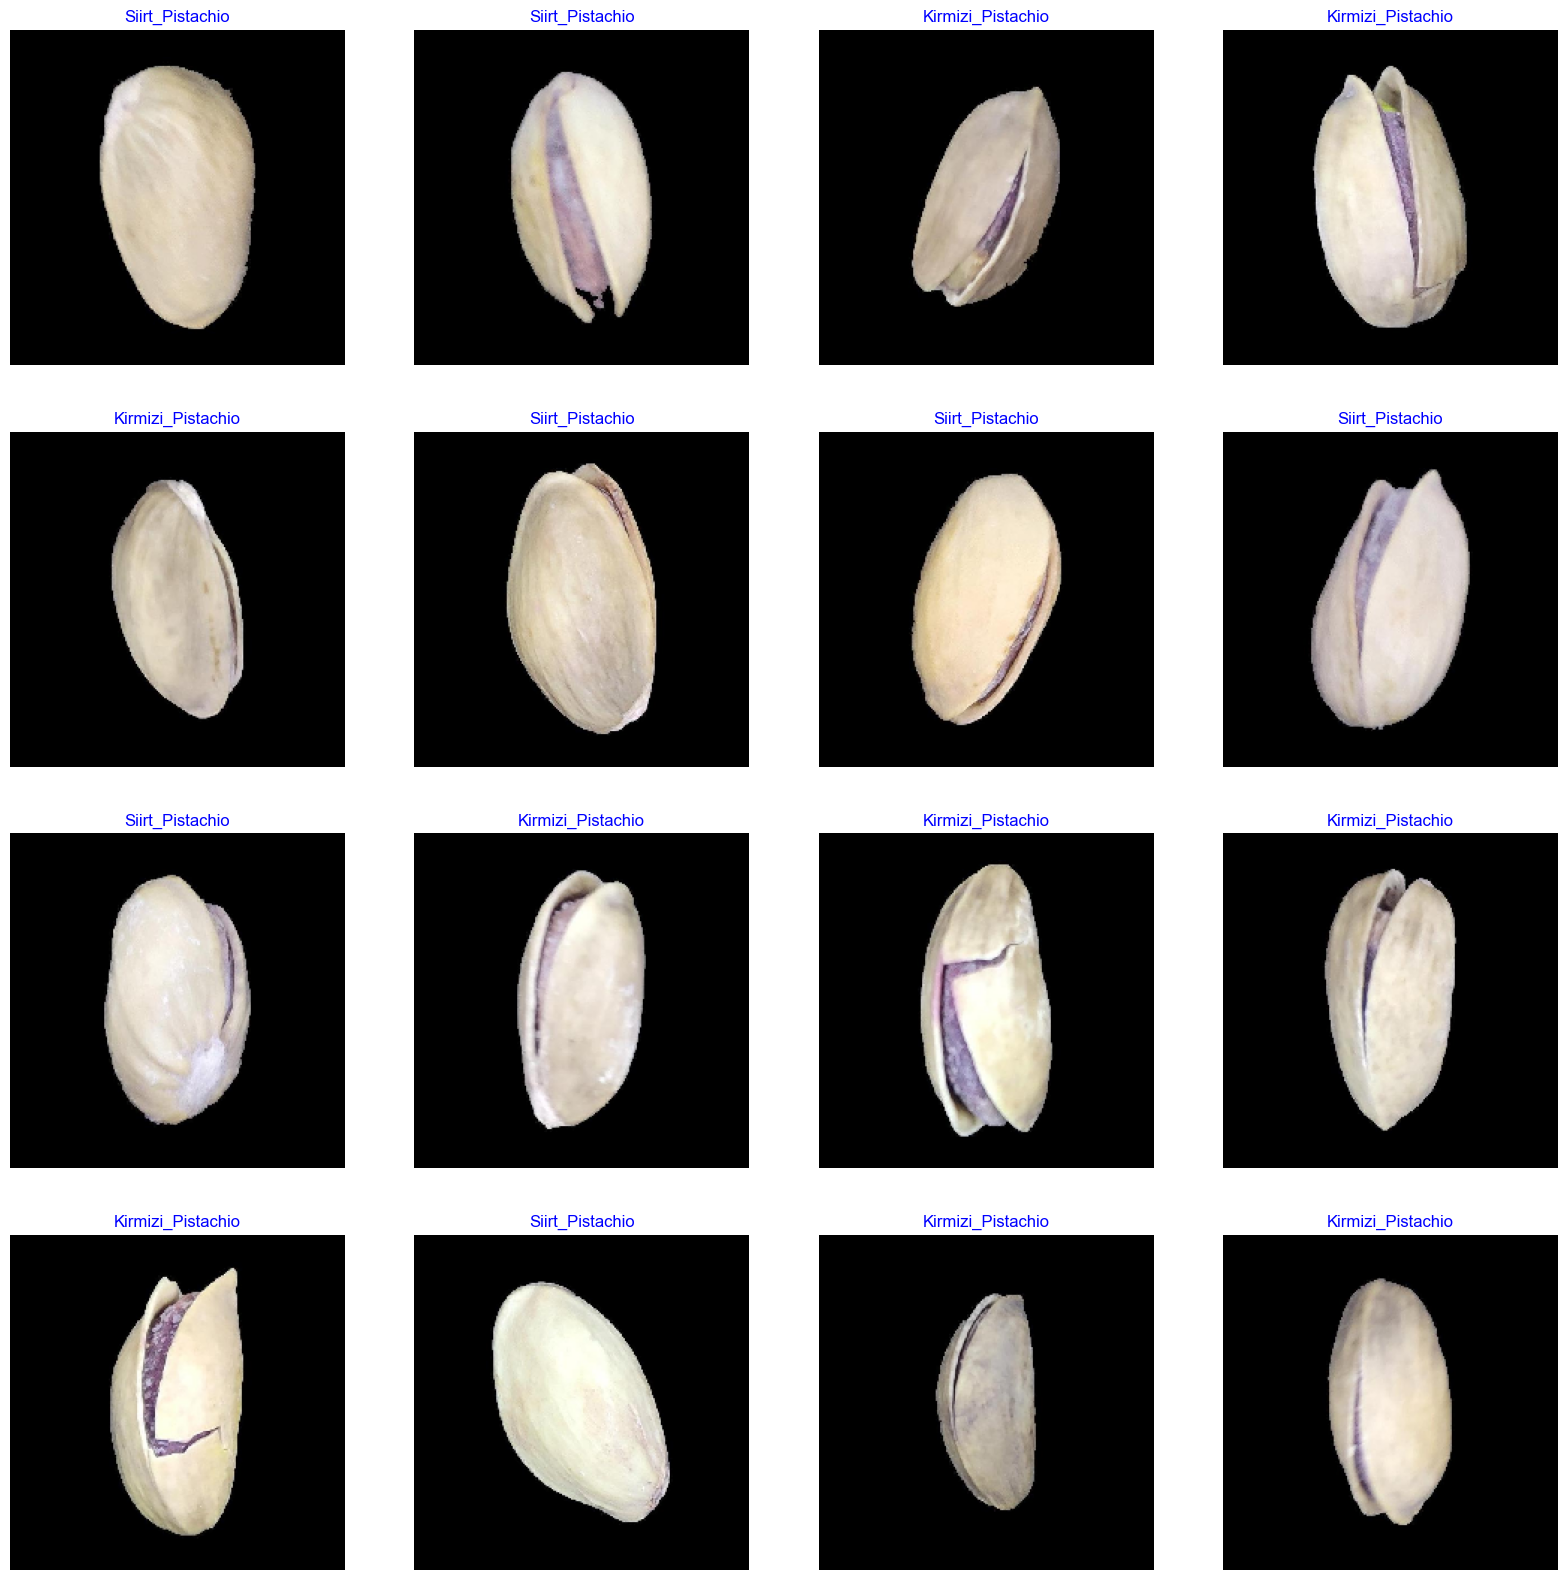

In [7]:
# ٍShow Random Smaples from the Data
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [8]:
# Define input image dimensions
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Define number of classes

# Define the input layer
inputs = tf.keras.Input(shape=img_shape)

# Load the pre-trained EfficientNetB3 model without the top layer
base_model = keras.applications.EfficientNetB3(include_top=False, weights="imagenet", 
input_tensor=inputs)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling to match the target shape
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [9]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with frozen layers
history1 = model.fit(train_gen, epochs=15, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/15
108/108 [==============================] - 29s 213ms/step - loss: 7.4707 - accuracy: 0.7573 - val_loss: 5.0900 - val_accuracy: 0.8698
Epoch 2/15
108/108 [==============================] - 8s 78ms/step - loss: 4.9578 - accuracy: 0.8969 - val_loss: 3.8850 - val_accuracy: 0.9349
Epoch 3/15
108/108 [==============================] - 8s 77ms/step - loss: 3.8146 - accuracy: 0.9244 - val_loss: 3.0736 - val_accuracy: 0.9674
Epoch 4/15
108/108 [==============================] - 8s 76ms/step - loss: 3.0256 - accuracy: 0.9428 - val_loss: 2.4707 - val_accuracy: 0.9674
Epoch 5/15
108/108 [==============================] - 8s 75ms/step - loss: 2.4387 - accuracy: 0.9403 - val_loss: 2.0075 - val_accuracy: 0.9721
Epoch 6/15
108/108 [==============================] - 24s 220ms/step - loss: 2.0267 - accuracy: 0.9307 - val_loss: 1.6642 - val_accuracy: 0.9767
Epoch 7/15
108/108 [==============================] - 11s 99ms/step - loss: 1.6512 - accuracy: 0.9411 - val_loss: 1.3723 - val_accuracy: 0

In [10]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

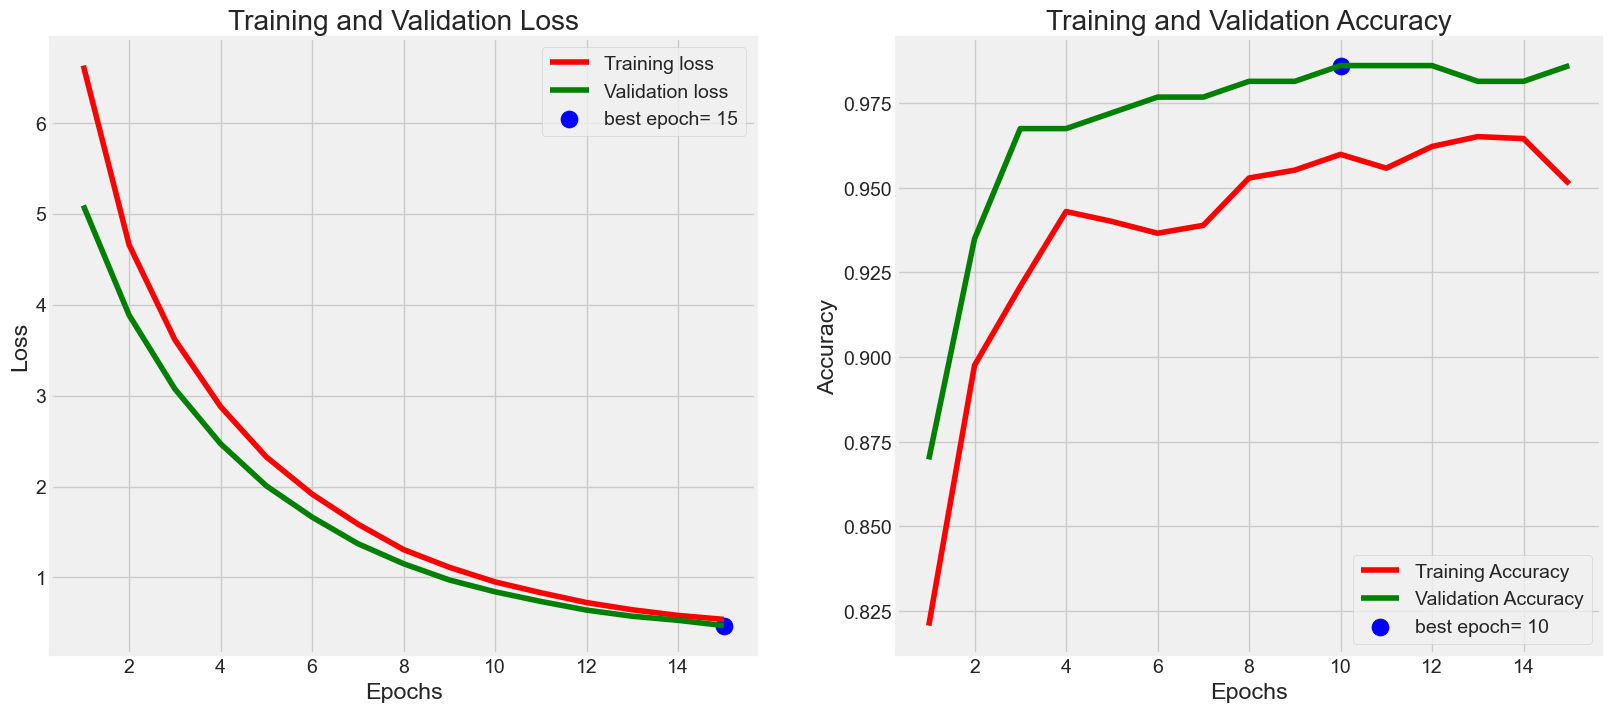

In [11]:
plot_training(history1)

In [12]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 1s 185ms/step - loss: 0.4684 - accuracy: 0.9875
Train Loss:  0.43156933784484863
Train Accuracy:  1.0
--------------------
Validation Loss:  0.477836549282074
Validation Accuracy:  0.9750000238418579
--------------------
Test Loss:  0.46837443113327026
Test Accuracy:  0.987500011920929


###ResNet50

In [13]:
# Define input image dimensions
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Define number of classes

# Define the input layer
inputs = tf.keras.Input(shape=img_shape)

# Load the pre-trained EfficientNetB3 model without the top layer
base_model = keras.applications.ResNet50(include_top=False, weights="imagenet", 
input_tensor=inputs)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling to match the target shape
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [14]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]
history2 = model.fit(train_gen, epochs=15, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/15
108/108 [==============================] - 11s 87ms/step - loss: 7.3994 - accuracy: 0.8359 - val_loss: 5.1743 - val_accuracy: 0.8791
Epoch 2/15
108/108 [==============================] - 7s 65ms/step - loss: 4.8846 - accuracy: 0.9323 - val_loss: 3.8712 - val_accuracy: 0.9349
Epoch 3/15
108/108 [==============================] - 7s 69ms/step - loss: 3.7504 - accuracy: 0.9384 - val_loss: 3.0620 - val_accuracy: 0.9628
Epoch 4/15
108/108 [==============================] - 7s 69ms/step - loss: 2.9293 - accuracy: 0.9829 - val_loss: 2.4603 - val_accuracy: 0.9860
Epoch 5/15
108/108 [==============================] - 7s 67ms/step - loss: 2.3343 - accuracy: 0.9771 - val_loss: 1.9873 - val_accuracy: 0.9767
Epoch 6/15
108/108 [==============================] - 7s 67ms/step - loss: 1.8698 - accuracy: 0.9860 - val_loss: 1.6187 - val_accuracy: 0.9814
Epoch 7/15
108/108 [==============================] - 8s 71ms/step - loss: 1.5252 - accuracy: 0.9830 - val_loss: 1.3205 - val_accuracy: 0.976

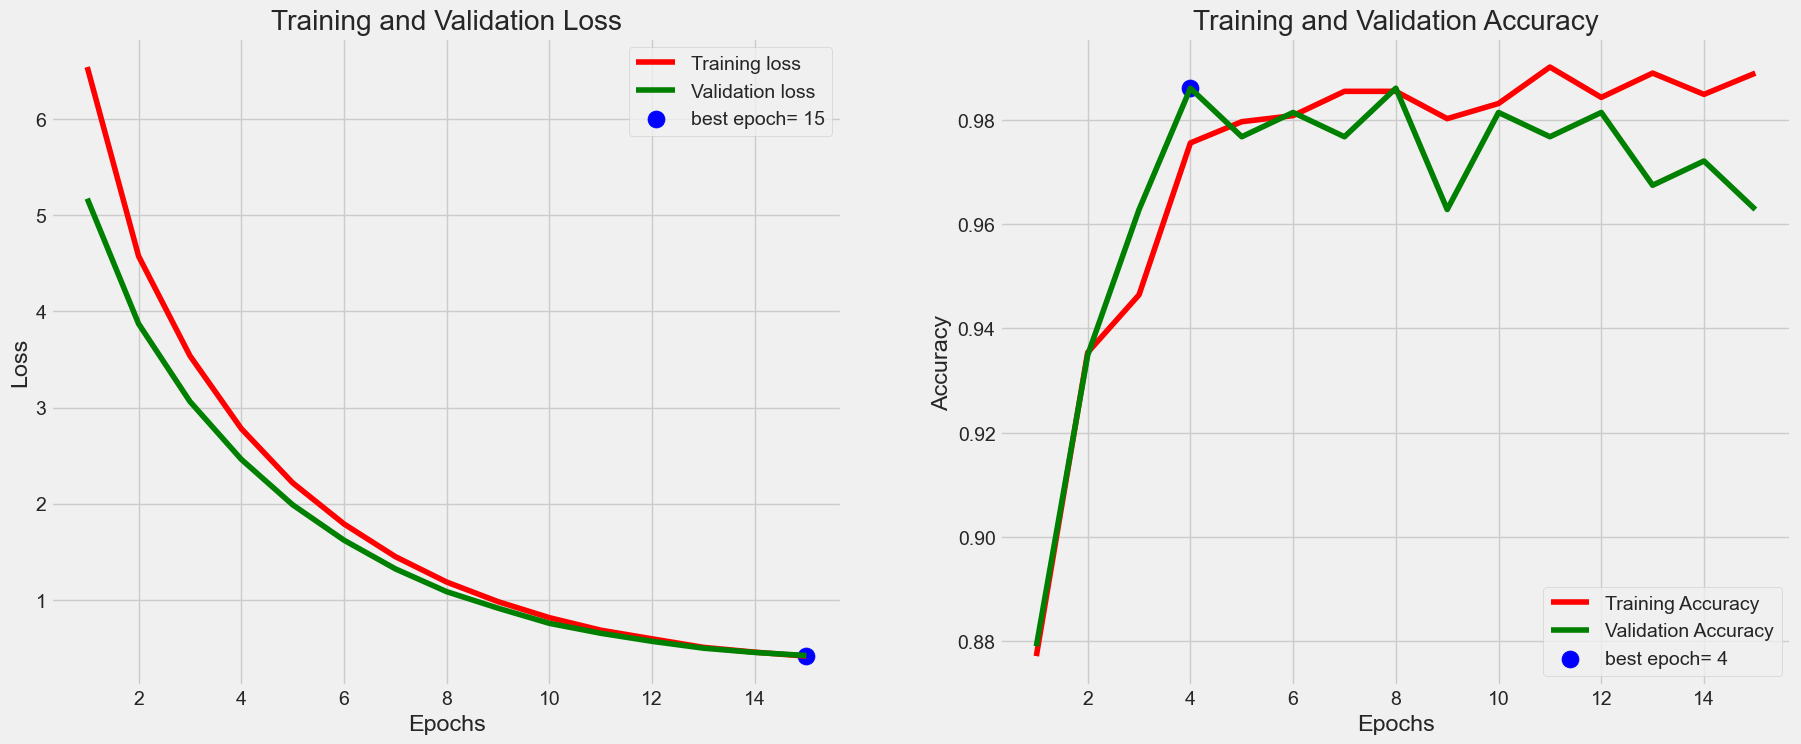

In [15]:
plot_training(history2)

评估模型

In [16]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 0s 57ms/step - loss: 0.4510 - accuracy: 0.9750
Train Loss:  0.34824174642562866
Train Accuracy:  1.0
--------------------
Validation Loss:  0.4487537443637848
Validation Accuracy:  0.949999988079071
--------------------
Test Loss:  0.4510076642036438
Test Accuracy:  0.9750000238418579


VGG16

In [17]:
# Define input image dimensions
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Define number of classes

# Define the input layer
inputs = tf.keras.Input(shape=img_shape)

# Load the pre-trained InceptionV3 model without the top layer
base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [18]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]
history3 = model.fit(train_gen, epochs=15, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/15
108/108 [==============================] - 19s 136ms/step - loss: 5.8263 - accuracy: 0.7930 - val_loss: 4.1894 - val_accuracy: 0.9349
Epoch 2/15
108/108 [==============================] - 10s 89ms/step - loss: 3.8808 - accuracy: 0.9384 - val_loss: 3.1461 - val_accuracy: 0.9488
Epoch 3/15
108/108 [==============================] - 10s 90ms/step - loss: 3.0259 - accuracy: 0.9377 - val_loss: 2.5233 - val_accuracy: 0.9628
Epoch 4/15
108/108 [==============================] - 10s 89ms/step - loss: 2.4083 - accuracy: 0.9568 - val_loss: 2.0756 - val_accuracy: 0.9581
Epoch 5/15
108/108 [==============================] - 10s 89ms/step - loss: 1.9983 - accuracy: 0.9456 - val_loss: 1.7304 - val_accuracy: 0.9628
Epoch 6/15
108/108 [==============================] - 10s 89ms/step - loss: 1.6420 - accuracy: 0.9600 - val_loss: 1.4439 - val_accuracy: 0.9628
Epoch 7/15
108/108 [==============================] - 10s 89ms/step - loss: 1.3630 - accuracy: 0.9647 - val_loss: 1.2168 - val_accuracy

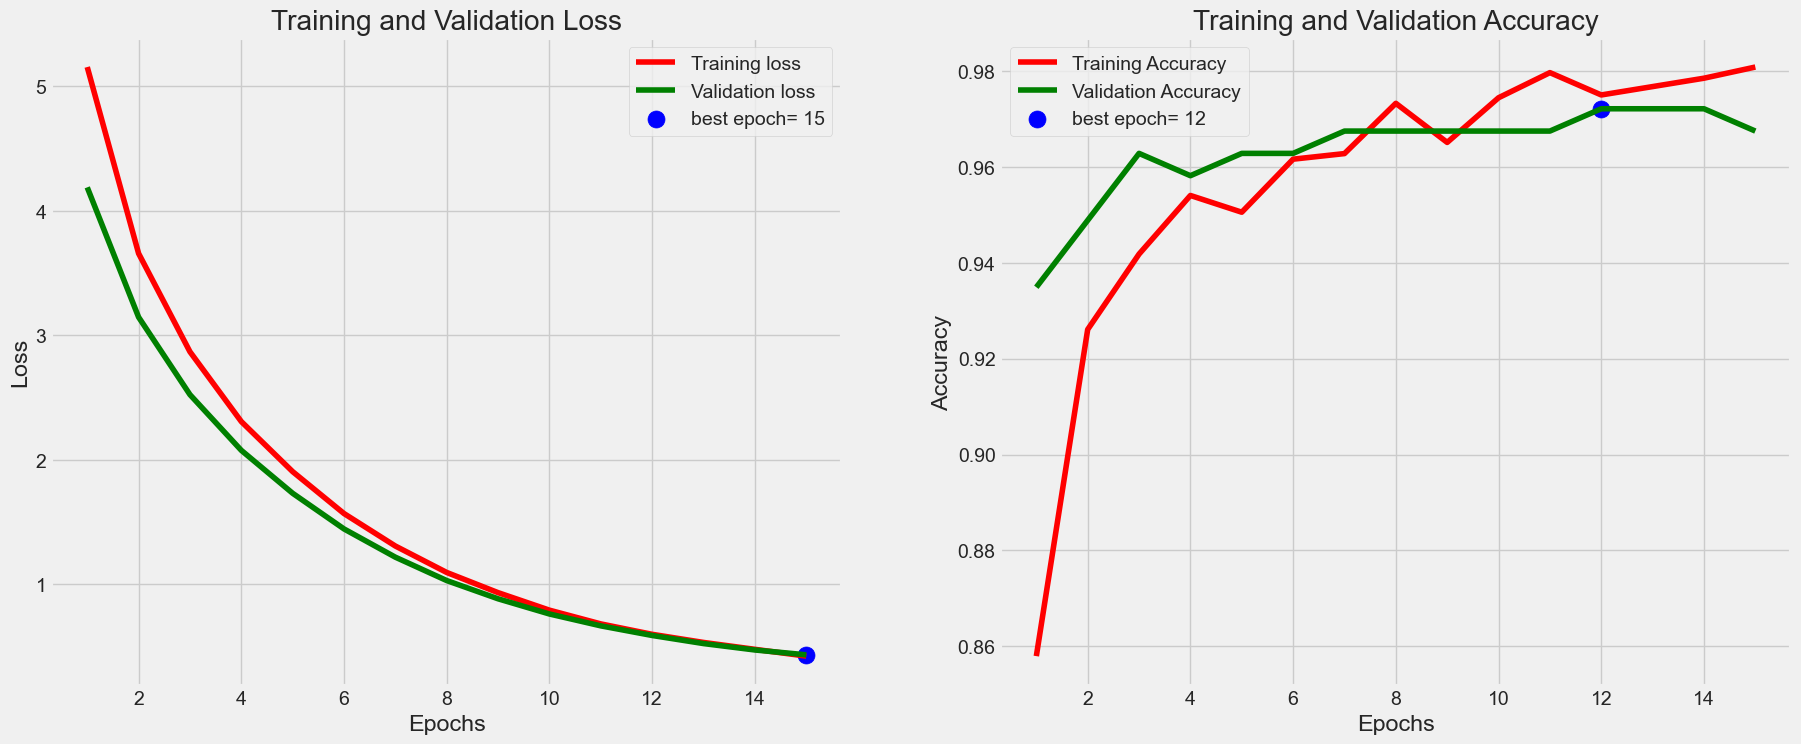

In [19]:
plot_training(history3)

In [20]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 1s 117ms/step - loss: 0.4157 - accuracy: 0.9750
Train Loss:  0.36885786056518555
Train Accuracy:  1.0
--------------------
Validation Loss:  0.41742563247680664
Validation Accuracy:  0.987500011920929
--------------------
Test Loss:  0.4157313406467438
Test Accuracy:  0.9750000238418579


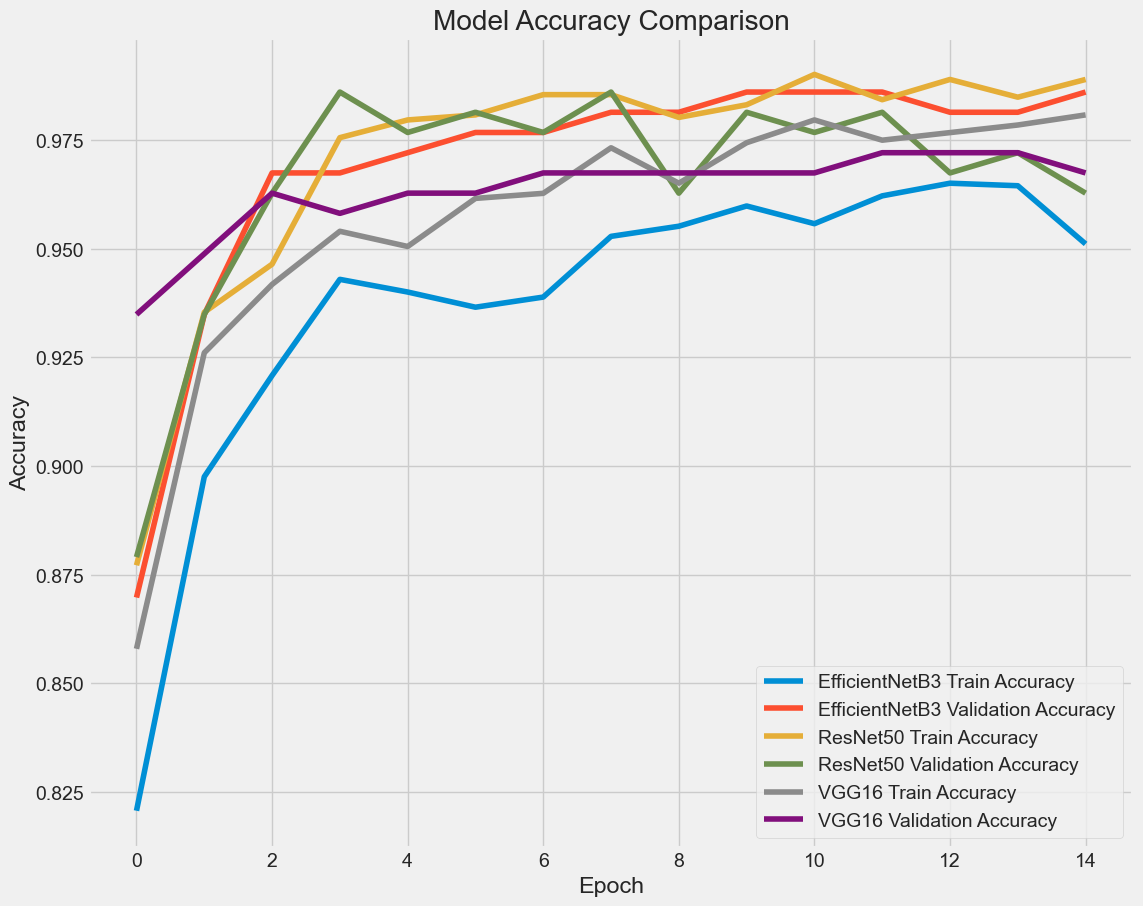

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 10))

# EfficientNetB3
plt.plot(history1.history['accuracy'], label='EfficientNetB3 Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='EfficientNetB3 Validation Accuracy')

# ResNet50
plt.plot(history2.history['accuracy'], label='ResNet50 Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='ResNet50 Validation Accuracy')

# VGG16
plt.plot(history3.history['accuracy'], label='VGG16 Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='VGG16 Validation Accuracy')

plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()